In [1]:
import pymc4 as pm
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as npr

# PyMC4 Made Simple for PyMC3 Users

In this notebook, we will use a simple Bayesian estimation example to learn how to use the PyMC4 syntax.

## Simulated Data

To keep things simple, we will use a simple example in which we generate 1,000 data points from a normal distribution with a pre-specified $\mu$ and $\sigma$.

In [4]:
MU = 8
SIG = 2.2

data = np.random.normal(loc=MU, scale=SIG, size=200)

The goal of our estimation task is to estimate the true value of $\mu$ and $\sigma$ from the observed data.

## Model Definition

PyMC models are defined as functions with a `@pm.model` decorator on top.

To specify random variables as Python objects, we use the `yield` statement. This stems from PyMC4's API design, which uses coroutines underneath the hood. The technical reason is documented in the PyMC4 design guide; what's cool here is that it also serves as a "visual hack" that lets you very quickly identify all of your random variables in a model. 

We're going to define our model in the code cell below.

As a prior for the $\mu$, we will use a relatively flat Normal distribution, and for the $\sigma$ prior, a relatively flat Exponential distribution.

Unlike PyMC3's distributions, which used spelled Greek letters as arguments, in PyMC4, we use the standardized "location", "scale", "rate" and "concentration" paradigm used by TensorFlow Probability's distributions, as well as NumPy.

In [5]:
@pm.model
def model(data):
    mu = yield pm.Normal(loc=0, scale=10, name="mu")
    sig = yield pm.Exponential(rate=0.1, name="sig")
    
    like = yield pm.Normal(loc=mu, scale=sig, observed=data, name="like")
    
    return like

## Sampling from Posterior

Sampling from posterior distributions is more or less the same as in PyMC3.

We call on the model function, and then pass the result to `pm.sample`.

Unlike PyMC3, `pm.sample(model)` now returns both the trace _and_ the computed sampling stats.

Give it a moment to sample; as of the alpha version of PyMC4, the progress bar is unavailable because sampling is also delegated to TensorFlow probability.

In [6]:
estimation_model = model(data)

trace = pm.sample(model(data), num_samples=800)

The trace returned is an ArviZ's InferenceData object, which is the central data format for ArviZ. InferenceData itself is just a container that maintains references to one or more `xarray.Dataset`. You can check the InferenceData structure specification [here](https://arviz-devs.github.io/arviz/schema/schema.html).

## Visualizing Posterior Distributions

Visualizations were completely delegated to `arviz` in PyMC3, and that is the same in PyMC4.

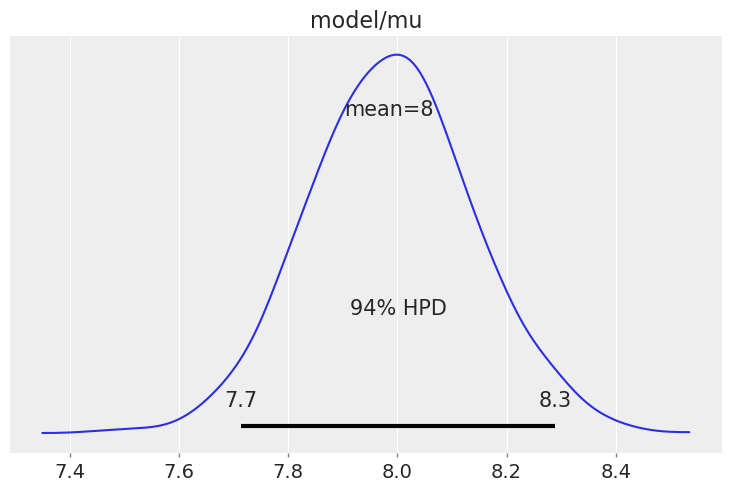

In [7]:
az.plot_posterior(trace, var_names="model/mu");

We recovered the true $\mu$!

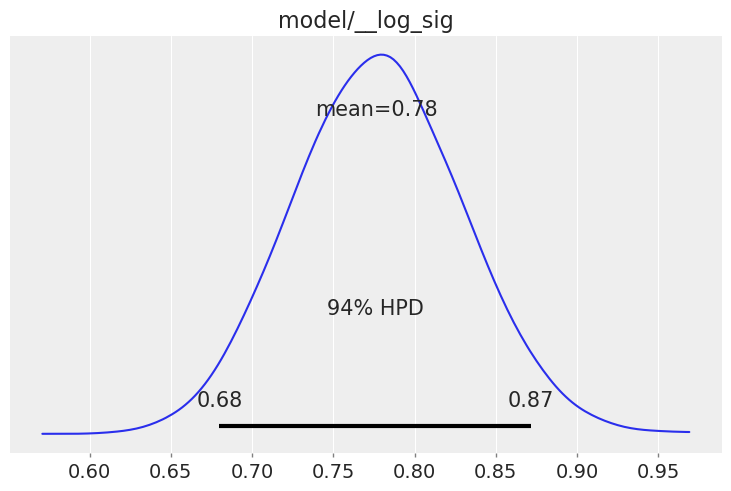

In [8]:
az.plot_posterior(trace, var_names="model/__log_sig");

If we take the exponent of the posterior distribution trace values, we will recover back approximately 2.2 for the $\sigma$ as well.

# Prior/Posterior Predictive Samples

Doing prior and posterior predictive sampling is an important part of the modelling workflow. Just like in PyMC3, this functionality has been added to PyMC4. 

In [9]:
draws_prior = pm.sample_prior_predictive(estimation_model)

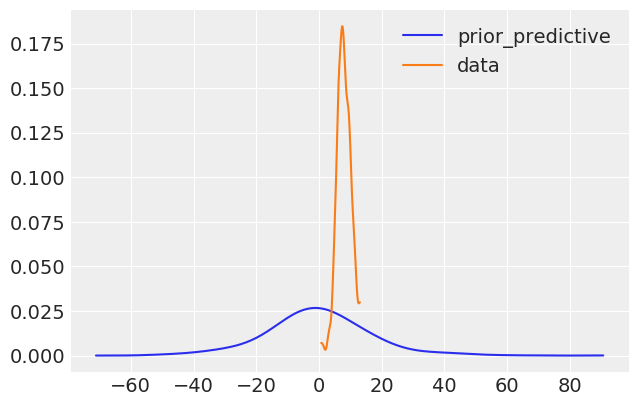

In [10]:
ax = az.plot_kde(draws_prior.prior_predictive['model/like'], label='prior_predictive');
ax = az.plot_kde(data, label='data', plot_kwargs={'color':'C1'});

`draws_prior` Is also an InferenceData object as such is ordered into groups, in this case we have a single group `prior_predictive`.

In [11]:
draws_prior

Inference data with groups:
	> prior_predictive

We drew 1,000 i.i.d. samples from the prior distributions for each of the random variables.

In [12]:
draws_prior.prior_predictive

<xarray.Dataset>
Dimensions:     (chain: 1, draw: 1000)
Coordinates:
  * chain       (chain) int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    model/mu    (chain, draw) float32 -1.4433514 -6.5141153 ... 2.82711
    model/sig   (chain, draw) float32 2.595807 0.17294928 ... 34.99558 24.929535
    model/like  (chain, draw) float32 2.218423 -6.5267453 ... 37.448326
Attributes:
    created_at:  2019-12-21T03:15:53.586364

Let make predictions from the fitted model

In [13]:
draws_posterior = pm.sample_posterior_predictive(estimation_model, trace)

In [14]:
draws_posterior.posterior_predictive

<xarray.Dataset>
Dimensions:           (chain: 10, draw: 800, model/like_dim_0: 200)
Coordinates:
  * chain             (chain) int64 0 1 2 3 4 5 6 7 8 9
  * draw              (draw) int64 0 1 2 3 4 5 6 ... 793 794 795 796 797 798 799
  * model/like_dim_0  (model/like_dim_0) int64 0 1 2 3 4 ... 195 196 197 198 199
Data variables:
    model/like        (chain, draw, model/like_dim_0) float32 8.665809 ... 5.7090855
Attributes:
    created_at:  2019-12-21T03:15:54.974436

We had 10 chains, 800 samples for each observation (1st and 2nd dim) and 1000 observations.

To make this clearer, Luciano Paz (one of the PyMC developers) provided the following explanation:

> The shape of the output for a posterior predictive samples is (n_chains, samples_per_chain) + shape_of_rv output
>
> The shape of the RV in posterior predictive sampling takes the shape of the supplied observed values into account. This is not like what prior predictive sampling does, where it only cares about the shape of the distribution.

InferenceData objects can be easily concatenated, so you can have all the relevant data in the same place

In [15]:
combined_trace = trace+draws_posterior+draws_prior

In [16]:
combined_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data

This is handy for example when performing posterior predictive checks

/home/osvaldo/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/osvaldo/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


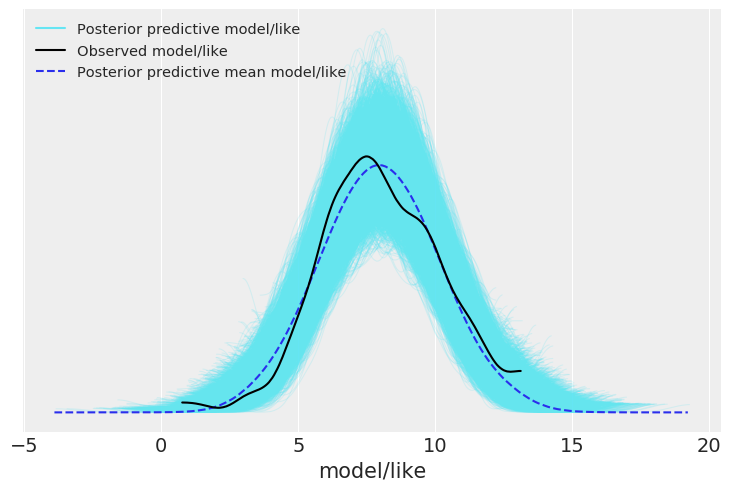

In [17]:
az.plot_ppc(combined_trace);